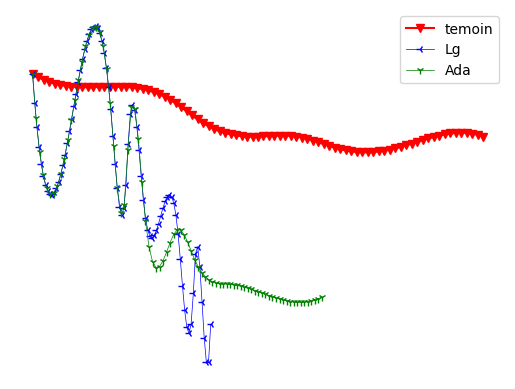

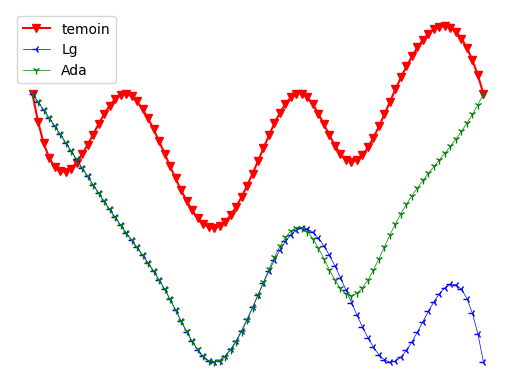

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d
%matplotlib inline
import numpy as np
import pickle
import random
from math import radians, sin, cos


MODELS_PATH= "../models/"
MODELS_TEST_PATH= "../models/test/"

PATH_LENGTH = 10

def compute_point(point_to_be_rotated, angle, center_point = (0,0)):
    angle = radians(angle)
    xnew = cos(angle)*(point_to_be_rotated[0] - center_point[0]) - sin(angle)*(point_to_be_rotated[1] - center_point[1]) + center_point[0]
    ynew = sin(angle)*(point_to_be_rotated[0] - center_point[0]) + cos(angle)*(point_to_be_rotated[1] - center_point[1]) + center_point[1]
    return xnew,ynew

def prepare_pred(y_test):
        y_test = [-1 if num == 2 else num for num in y_test]
        y_test = np.insert(y_test,0,0)
        return y_test

def make_allways_turn_path(y_test):     
        lst = [0,1]
        y_test_ref = [0,0]
        for ind, y in  enumerate(y_test):
                if ind:
                        lst[ind], y_test_ref[ind] = compute_point((lst[ind], y_test_ref[ind]), 23 if y > 0  else -23, (lst[ind-1],y_test_ref[ind-1]))
                        if (ind < len(y_test) - 1):
                                lst.append(lst[ind] + (lst[ind] - lst[ind-1]))
                                y_test_ref.append(y_test_ref[ind] + (y_test_ref[ind] - y_test_ref[ind-1]))
        cubic_interpolation_model = interp1d(lst, y_test_ref, kind = "cubic")
        X_ = np.linspace(min(lst), max(lst), 83)
        return X_, cubic_interpolation_model(X_)
   
def make_turn_when_change_path(y_test):
        lst = range(0, len(y_test))
        y_test = [ sum(y_test[:ind+1]) if ind > 0 else x for ind, x in enumerate(y_test)]
        cubic_interpolation_model = interp1d(lst, y_test, kind = "cubic")       
        X_=np.linspace(min(lst), max(lst), 83)
        return X_, cubic_interpolation_model(X_)

def graph(method, y_test, y_pred_lg, y_pred_ada):
        X_, Y_ = method(y_test)
        plt.plot(X_, Y_, 'rv', linestyle='solid', label ='temoin')
        X_, Y_ = method(y_pred_lg)
        plt.plot(X_, Y_, 'b3', linewidth=0.5, linestyle='solid',label ='Lg')
        X_, Y_ = method(y_pred_ada)
        plt.plot(X_, Y_, 'g1', linewidth=0.5, linestyle='solid', label ='Ada')
        plt.axis('off')
        plt.legend()
        plt.show()
        
X_test = pd.read_csv(MODELS_TEST_PATH + "X_test.csv")
y_test = pd.read_csv(MODELS_TEST_PATH + "y_test.csv")

lg_model = pickle.load(open(MODELS_PATH + "LogisticRegression", 'rb'))
ada_model = pickle.load(open(MODELS_PATH + "AdaBoost", 'rb'))

samples = random.sample(range(0, y_test.shape[0]), PATH_LENGTH)

y_test = y_test.iloc[samples]['eventType']
X_test = X_test.iloc[samples].drop(['Unnamed: 0', 'id', 'index'], axis=1)

y_pred_lg = lg_model.predict(X_test)
y_pred_ada = ada_model.predict(X_test)
y_pred_lg = [int(num) for num in y_pred_lg]
y_pred_ada = [int(num) for num in y_pred_ada]
y_pred_lg = prepare_pred(y_pred_lg)
y_pred_ada = prepare_pred(y_pred_ada)
y_test =  prepare_pred(y_test)

graph(make_allways_turn_path, y_test, y_pred_lg, y_pred_ada)
graph(make_turn_when_change_path, y_test, y_pred_lg, y_pred_ada)

